In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
T = 50
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 100
NUM_HIDDEN = 64
NUM_LATENTS = K*K
NUM_OBS =  2 * K
BATCH_SIZE = 100
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
# Ys = torch.from_numpy(np.load('dataset/sequences.npy')).float()
As_true = torch.from_numpy(np.load('hmm_dataset/transitions.npy')).float()
Zs = torch.from_numpy(np.load('hmm_dataset/states.npy')).float()
# mus_true = torch.from_numpy(np.load('dataset/means.npy')).float()
# covs_true = torch.from_numpy(np.load('dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('hmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior, num_samples, batch_size):
        As = torch.zeros((num_samples, batch_size, K, K))
        hidden = self.enc_hidden(obs)
        alphas = F.softmax(self.latent_dir(hidden), -1).view(batch_size, T-1, K*K).sum(1).view(batch_size, K, K) + prior
        for k in range(K):
            As[:, :, k, :] = Dirichlet(alphas[:, k, :]).sample((num_samples,))
        return alphas, As

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
def flatz(Z, T, K, batch_size):
    return torch.cat((Z[:, :T-1, :].unsqueeze(2), Z[:, 1:, :].unsqueeze(2)), 2).view(batch_size * (T-1), 2*K)

def eubo_rws(Zs, prior, Pi, T, K, num_samples, batch_size):
    """
    Zs is B-T-K
    As is S-B-K-K
    """
    Zs_pairs = flatz(Zs, T, K, batch_size)
    log_trans = torch.zeros((num_samples, batch_size)).float()
    labels = Zs.nonzero()
    inds = labels.view(batch_size, T, 3)[:, :-1, :].contiguous().view(batch_size * (T-1), 3)
    alphas, As = enc(Zs_pairs, prior, num_samples, batch_size)
    log_init = cat(Pi).log_prob(Zs[:, 0])
    log_prior = Dirichlet(prior).log_prob(As).sum(-1) ## prior of A
    for s in range(num_samples):
        log_trans[s] = (cat(As[s][inds[:, 0], inds[:, -1]].view(batch_size, T-1, K)).log_prob(Zs[:, 1:])).sum(1)
    log_q = Dirichlet(alphas).log_prob(As).sum(-1)
    log_weights = log_prior + log_init + log_trans - log_q
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    return eubo, elbo, ess

In [9]:
# ELBOs = []
# EUBOs = []
# ESSs = []
prior = torch.ones((K, K)).float()
for k in range(K):
    prior[k, k] = 2.0
NUM_EPOCHS = 310
Grad_Steps = int((Zs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    time_start = time.time()
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(Grad_Steps):
        optimizer.zero_grad()def save_params(ELBOs, KLs, PATH_ENC):
    with open(PATH_ENC + 'ELBOs.txt', 'w+') as felbo:
        for elbo in ELBOs:
            felbo.write("%s\n" % elbo)
    with open(PATH_ENC + 'KLs.txt', 'w+') as fkl:
        for kl in KLs:
            fkl.write("%s\n" % kl)
    felbo.close()
    fkl.close()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_zs = Zs[batch_indices]
        eubo, elbo, ess = eubo_rws(batch_zs, prior, Pi, T, K, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
    EUBO /= Grad_Steps
    ELBO /= Grad_Steps
    ESS /= Grad_Steps
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    time_end = time.time()
    print('epoch : %d, EUBO : %f, ELBO : %f (%ds)' % (epoch, EUBO, ELBO, time_end - time_start))

epoch : 0, EUBO : -34.620590, ELBO : -34.671976 (2s)
epoch : 1, EUBO : -34.621057, ELBO : -34.672028 (2s)
epoch : 2, EUBO : -34.619724, ELBO : -34.670756 (2s)
epoch : 3, EUBO : -34.620645, ELBO : -34.671014 (2s)
epoch : 4, EUBO : -34.619438, ELBO : -34.670171 (2s)
epoch : 5, EUBO : -34.620700, ELBO : -34.670750 (2s)
epoch : 6, EUBO : -34.620175, ELBO : -34.669505 (2s)
epoch : 7, EUBO : -34.620960, ELBO : -34.670250 (2s)
epoch : 8, EUBO : -34.620424, ELBO : -34.669269 (2s)
epoch : 9, EUBO : -34.620745, ELBO : -34.668906 (2s)
epoch : 10, EUBO : -34.621976, ELBO : -34.669924 (2s)
epoch : 11, EUBO : -34.620776, ELBO : -34.668937 (2s)
epoch : 12, EUBO : -34.620432, ELBO : -34.668394 (2s)
epoch : 13, EUBO : -34.620858, ELBO : -34.667963 (2s)
epoch : 14, EUBO : -34.622266, ELBO : -34.668429 (2s)
epoch : 15, EUBO : -34.620451, ELBO : -34.666860 (2s)
epoch : 16, EUBO : -34.622782, ELBO : -34.668459 (2s)
epoch : 17, EUBO : -34.622024, ELBO : -34.667416 (2s)
epoch : 18, EUBO : -34.621651, ELBO : 

In [10]:
len(ESSs)

1000

In [11]:
def plot_results(EUBOs, ELBOs):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.legend(fontsize=18)
    ax1.set_xlabel('epoch', fontsize=16)
    ax1.set_ylabel('EUBO and ELBO', fontsize=16)
    ax1.tick_params(labelsize=18)
    plt.savefig('results_VAE_hmm_samples=%d.svg' % (NUM_SAMPLES))

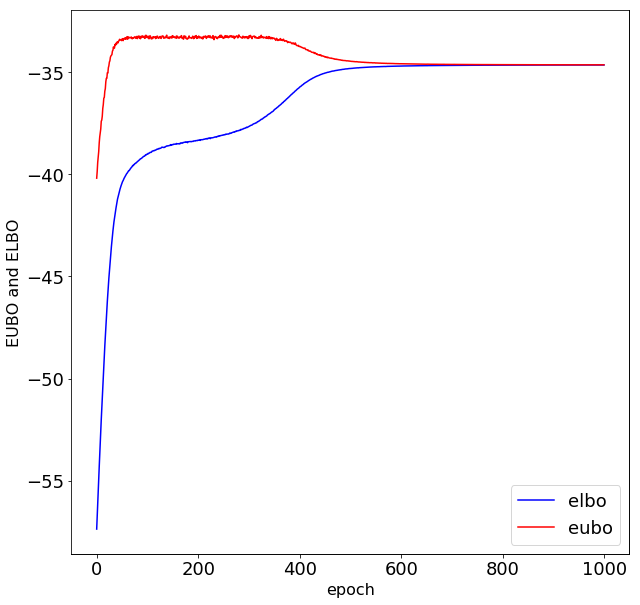

In [12]:
plot_results(EUBOs, ELBOs)

In [15]:
save_params(EUBOs, ELBOs, ESSs, 'VAE_hmm_samples=%d' % (NUM_SAMPLES))

In [14]:
def save_params(EUBOs, ELBOs, ESSs, PATH_ENC):
    with open(PATH_ENC + 'ELBOs.txt', 'w+') as felbo:
        for elbo in ELBOs:
            felbo.write("%s\n" % elbo)
    with open(PATH_ENC + 'EUBOs.txt', 'w+') as feubo:
        for eubo in EUBOs:
            feubo.write("%s\n" % eubo)
            
    with open(PATH_ENC + 'ESSs.txt', 'w+') as fess:
        for ess in ESSs:
            fess.write("%s\n" % ess)
    felbo.close()
    feubo.close()
    fess.close()